# Robotic Localization



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hallway_width = 0.55
hallway_length = 10.0

true_pos = (0.5, 0.4)

Nx = 200
Ny = 100

In [3]:
def FormatPlots():
    plt.xlim([-0.2,hallway_length+0.2])
    plt.ylim([-0.1, hallway_width+0.3])

    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()

In [4]:
def UpperFunction(x):
    
    output = hallway_width
    
    if(x<0):
        return 0.0
    if(x>hallway_length):
        return 0.0
    
    bumps = [ [1.5,2.5], [4.5,6.0], [6.5,7.5]]
    for bump in bumps:
        if((x>bump[0])&(x<bump[1])):
            output += 0.2
    
    return output

In [5]:
xs = np.linspace(-0.1,hallway_length+0.1, Nx)

upper = np.zeros(Nx)
bottom = np.zeros(Nx)
for i in range(Nx):
    upper[i] = UpperFunction(xs[i])


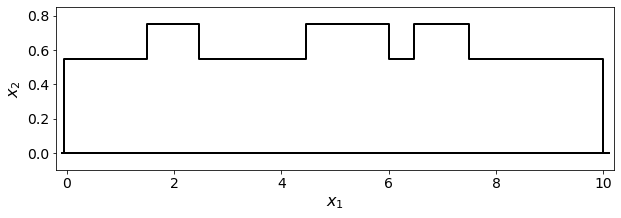

In [6]:
plt.figure(figsize=(10,3))

plt.step(xs, upper, '-k', linewidth=2)
plt.step(xs, bottom, '-k', linewidth=2)

FormatPlots()

In [7]:
ys = np.linspace(0,hallway_width+0.2, Ny)

X, Y = np.meshgrid(xs,ys)

In [8]:
def Prior(X,Y):
    
    priorDens = np.zeros(X.shape)
    for col in range(X.shape[1]):
        priorDens[Y[:,col]<upper[col],col] = 1.0
        priorDens[Y[:,col]<0.001, col] = 0.0
        
    return priorDens

In [9]:
prior = Prior(X,Y)

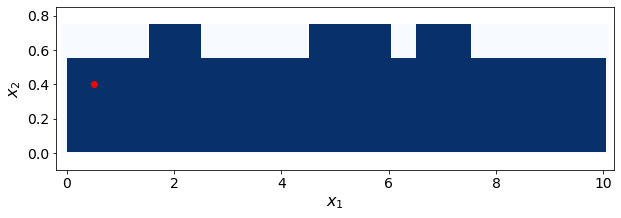

In [10]:
plt.figure(figsize=(10,3))
plt.pcolormesh(xs, ys, prior, cmap='Blues')

plt.plot(true_pos[0],true_pos[1], 'or')

FormatPlots()

In [11]:
def SonarLikelihood(X0, Y0, horz_shift, dist_to_upper):
    """
    ARGS:
        X0 (np.array): A 2D matrix of possible horizontal starting locations
        Y0 (np.array): A 2D matrix of possible vertical starting positions (should be the same shape as X0)
        horz_shift: How far the robot has moved horizontally from its initial position\
        dist_to_upper: A noisy observation of the distance to the upper wall at the point (X0+horz_shift, Y0)
        
    RETURNS:
        np.array: A 2D matrix of the likelihood function (up to a normalizing constant)
        
    """
    
    obs_var = 0.01
    likely = np.zeros(X0.shape)
    for i in range(X0.shape[0]):
        for j in range(X0.shape[1]):
            likely[i,j] = np.exp(-(0.5/obs_var)*(UpperFunction(X0[i,j]+horz_shift)-Y[i,j]-dist_to_upper)**2)
            
    return likely
    
likely = SonarLikelihood(X,Y, 0.0, UpperFunction(true_pos[0])-true_pos[1])

post = likely*prior

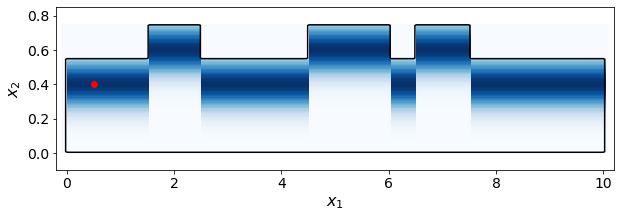

In [12]:
plt.figure(figsize=(10,3))

plt.pcolormesh(xs,ys,post, cmap='Blues')
plt.contour(xs,ys,prior,levels=[0.5], colors='k')

plt.plot(true_pos[0],true_pos[1], 'or')

FormatPlots()

In [13]:
def MoveLikelihood(X,Y, horz_dist):
    
    result = np.ones(X.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            
            if(Y[i,j]>UpperFunction(X[i,j]+horz_dist)):
                result[i,j] = 0.0
                
    return result

In [14]:
horz_shift = 0.1
likely2 = MoveLikelihood(X,Y,horz_shift)

post = post*likely2

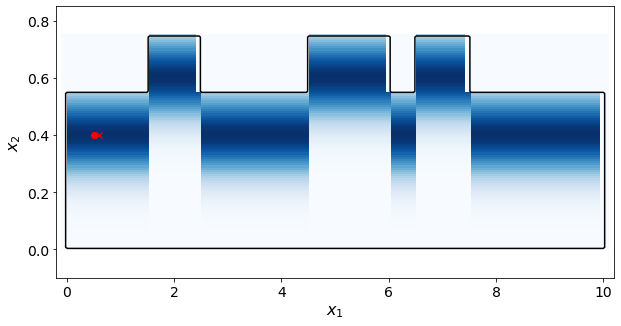

In [15]:
plt.figure(figsize=(10,5))
plt.pcolormesh(xs,ys,post, cmap='Blues')
plt.contour(xs,ys,prior,levels=[0.5], colors='k')

plt.plot(true_pos[0],true_pos[1], 'or')
plt.plot(true_pos[0]+horz_shift,true_pos[1], 'xr')

FormatPlots()

In [16]:
likely = SonarLikelihood(X,Y, 0.0, UpperFunction(true_pos[0])-true_pos[1])
post = post*likely

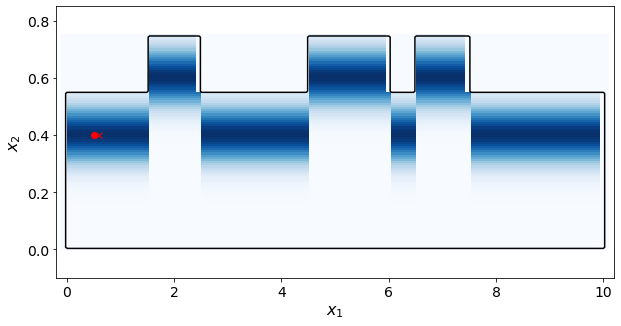

In [17]:
plt.figure(figsize=(10,5))
plt.pcolormesh(xs,ys,post, cmap='Blues')
plt.contour(xs,ys,prior,levels=[0.5], colors='k')

plt.plot(true_pos[0],true_pos[1], 'or')
plt.plot(true_pos[0]+horz_shift,true_pos[1], 'xr')

FormatPlots()

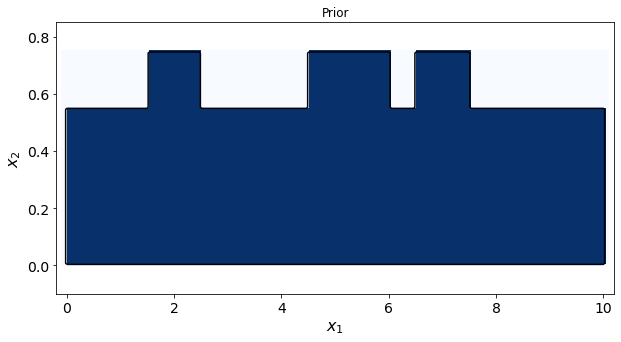

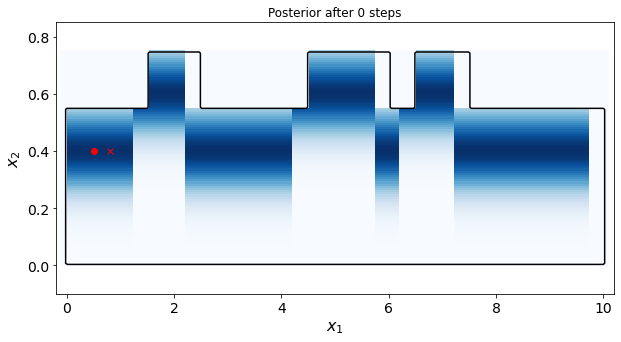

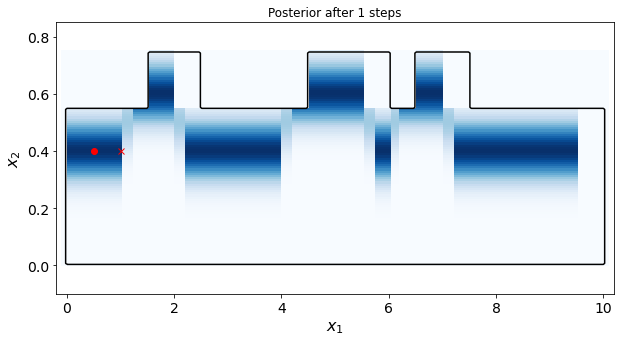

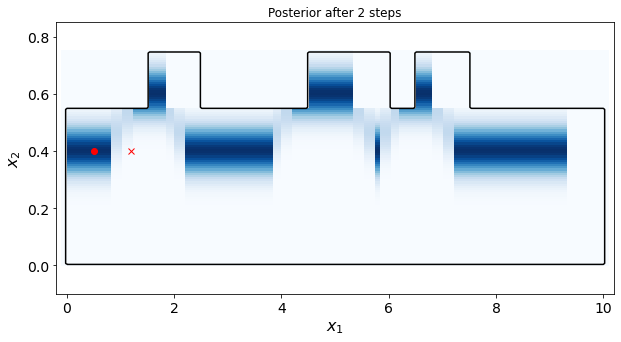

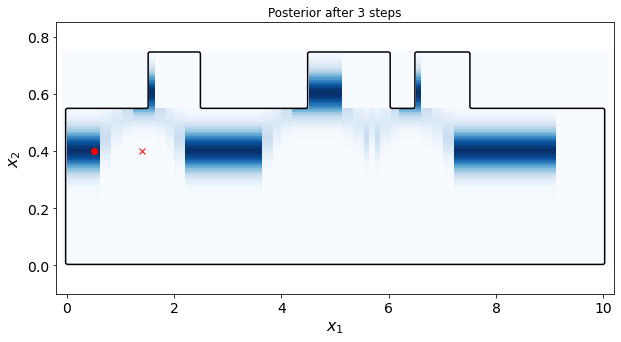

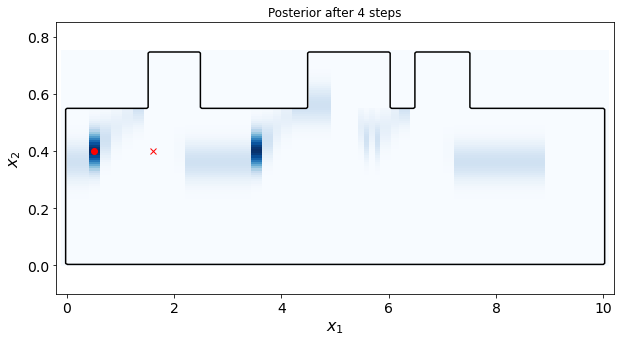

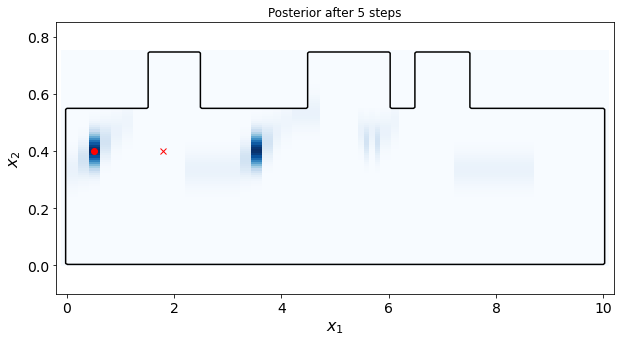

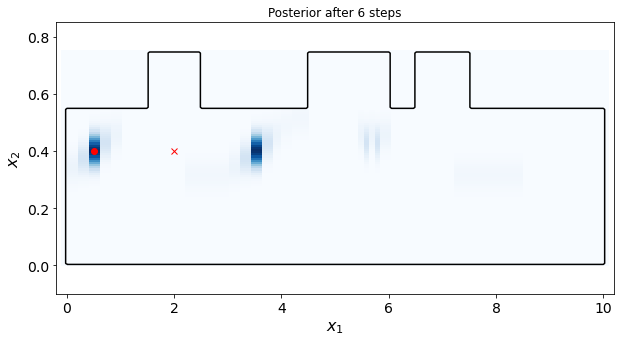

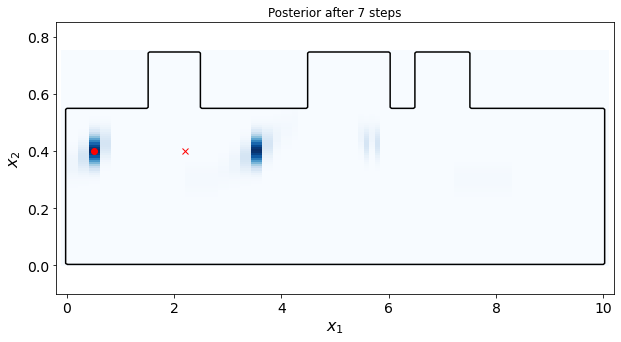

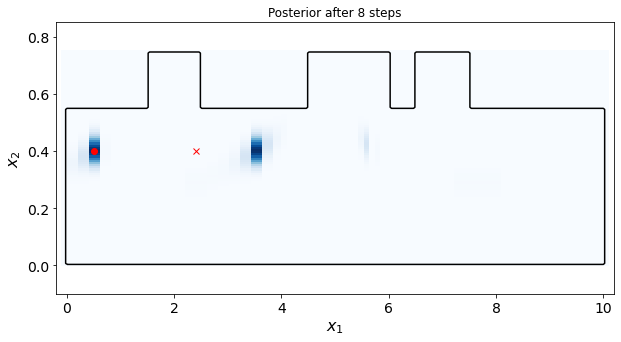

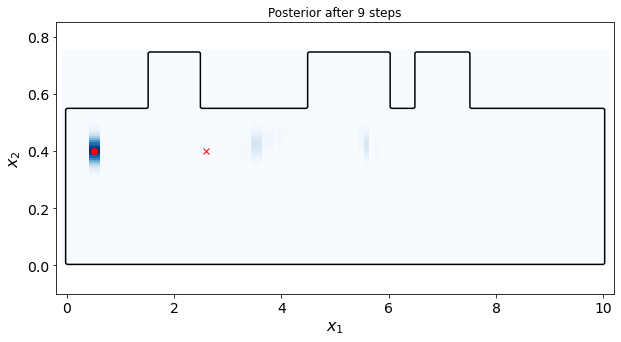

In [18]:
step_size = 0.2

post = np.copy(prior)
plt.figure(figsize=(10,5))
plt.pcolormesh(xs,ys,prior, cmap='Blues')
plt.contour(xs,ys,prior,levels=[0.5], colors='k')
    
plt.title('Prior')
FormatPlots()


for i in range(10):
    horz_shift += step_size
    
    likely1 = MoveLikelihood(X,Y,horz_shift)
    likely2 = SonarLikelihood(X, Y, horz_shift, UpperFunction(true_pos[0]+horz_shift)-true_pos[1])
    post = post*likely1*likely2
    
    plt.figure(figsize=(10,5))
    plt.pcolormesh(xs,ys,post, cmap='Blues')
    plt.contour(xs,ys,prior,levels=[0.5], colors='k')
    
    plt.plot(true_pos[0],true_pos[1], 'or')
    plt.plot(true_pos[0]+horz_shift,true_pos[1], 'xr')
    plt.title('Posterior after %i steps'%i)
    
    FormatPlots()

plt.show()